In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define transformations: normalize images to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
import torch.nn as nn
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 28x28 → 7x7 latent
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 7x7
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Instantiate the model
model = ConvAutoencoder().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [5]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [7]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, _ in train_loader:  # Ignore labels (_)
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')


Epoch [1/20], Loss: 0.8335
Epoch [2/20], Loss: 0.8334
Epoch [3/20], Loss: 0.8334
Epoch [4/20], Loss: 0.8333
Epoch [5/20], Loss: 0.8333
Epoch [6/20], Loss: 0.8333
Epoch [7/20], Loss: 0.8332
Epoch [8/20], Loss: 0.8332
Epoch [9/20], Loss: 0.8332
Epoch [10/20], Loss: 0.8332
Epoch [11/20], Loss: 0.8332
Epoch [12/20], Loss: 0.8331
Epoch [13/20], Loss: 0.8331
Epoch [14/20], Loss: 0.8331
Epoch [15/20], Loss: 0.8331
Epoch [16/20], Loss: 0.8331
Epoch [17/20], Loss: 0.8331
Epoch [18/20], Loss: 0.8331
Epoch [19/20], Loss: 0.8331
Epoch [20/20], Loss: 0.8331


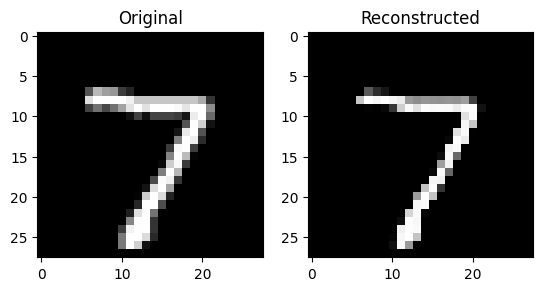

In [8]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)

        # Display original and reconstructed images
        fig, axes = plt.subplots(1, 2)

        # Original image
        axes[0].imshow(images[0].cpu().squeeze(), cmap='gray')
        axes[0].set_title("Original")

        # Reconstructed image
        axes[1].imshow(outputs[0].cpu().squeeze(), cmap='gray')
        axes[1].set_title("Reconstructed")

        plt.show()
        break


In [11]:
import numpy as np
from sklearn.manifold import TSNE

# Extract latent representations
latent_vectors = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        latent_repr = model.encoder(images)

        # Flatten spatial dimensions (if using convolutional layers)
        latent_repr_flat = latent_repr.view(latent_repr.size(0), -1).cpu().numpy()

        latent_vectors.append(latent_repr_flat)  # Now 2D: [batch_size, features]

latent_vectors = np.concatenate(latent_vectors)  # Shape: [n_samples, n_features]

# Now apply t-SNE
latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)


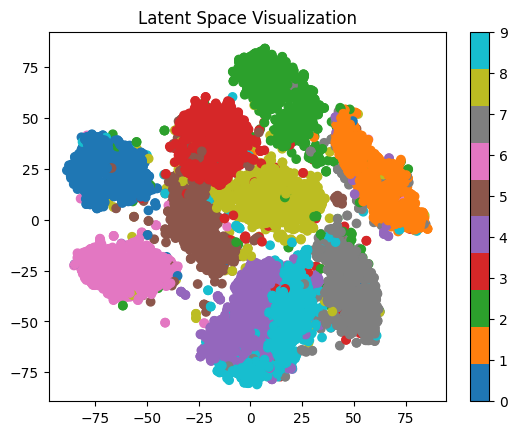

In [12]:
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_dataset.targets.numpy(), cmap='tab10')
plt.colorbar()
plt.title("Latent Space Visualization")
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*7*7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)

        # Reparameterization
        z = self.reparameterize(mu, logvar)

        # Decode
        return self.decoder(z), mu, logvar


In [14]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE for pixel-wise probability)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence regularization
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [17]:
# Hyperparameters
latent_dim = 20
batch_size = 128
epochs = 20

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [18]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch} Average loss: {train_loss/len(train_loader.dataset):.2f}')

for epoch in range(1, epochs+1):
    train(epoch)


Epoch 1 Average loss: 167.42
Epoch 2 Average loss: 120.37
Epoch 3 Average loss: 114.55
Epoch 4 Average loss: 111.10
Epoch 5 Average loss: 108.96
Epoch 6 Average loss: 107.62
Epoch 7 Average loss: 106.67
Epoch 8 Average loss: 105.99
Epoch 9 Average loss: 105.43
Epoch 10 Average loss: 104.98
Epoch 11 Average loss: 104.56
Epoch 12 Average loss: 104.24
Epoch 13 Average loss: 103.90
Epoch 14 Average loss: 103.63
Epoch 15 Average loss: 103.40
Epoch 16 Average loss: 103.16
Epoch 17 Average loss: 102.95
Epoch 18 Average loss: 102.77
Epoch 19 Average loss: 102.58
Epoch 20 Average loss: 102.40


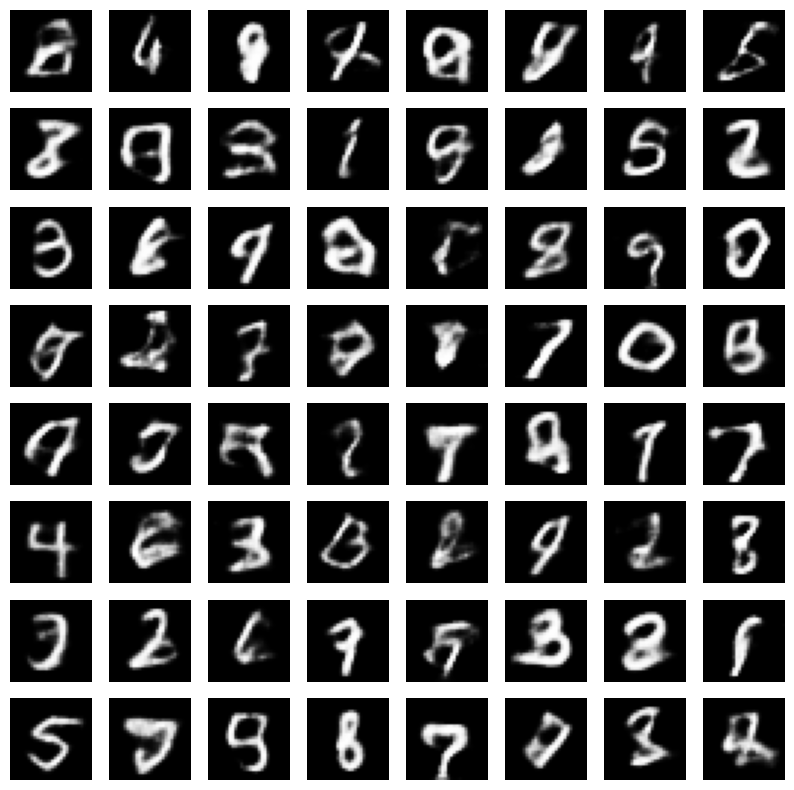

In [19]:
import matplotlib.pyplot as plt

with torch.no_grad():
    # Sample from latent space
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decoder(z).cpu()

# Display generated images
fig, ax = plt.subplots(8, 8, figsize=(10,10))
for i in range(64):
    ax[i//8][i%8].imshow(samples[i].squeeze(), cmap='gray')
    ax[i//8][i%8].axis('off')


Text(0.5, 1.0, 'Latent Space Visualization')

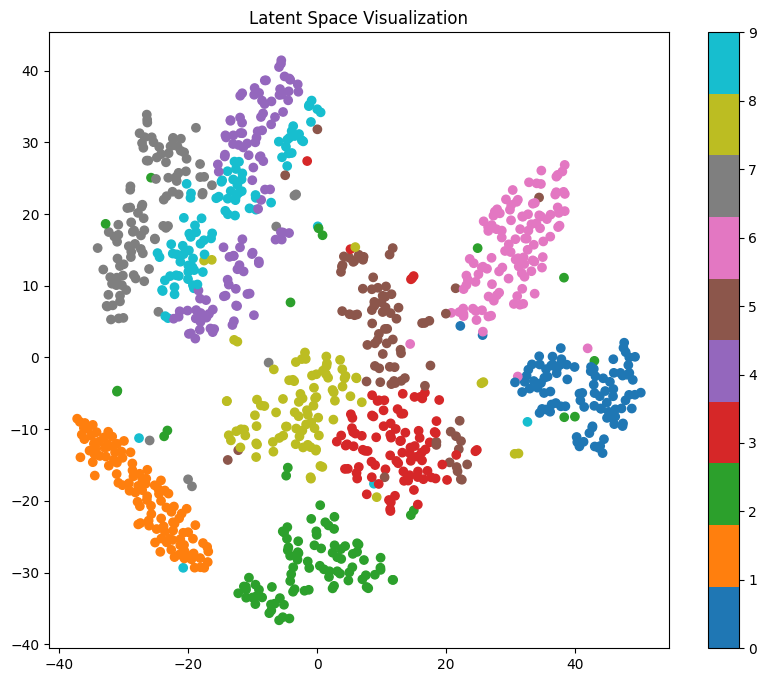

In [20]:
from sklearn.manifold import TSNE

# Encode test data
test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform),
                        batch_size=1000, shuffle=True)
data, labels = next(iter(test_loader))
data = data.to(device)

with torch.no_grad():
    mu, _ = model.encoder(data), model.fc_logvar(model.encoder(data))
    latent = mu.cpu().numpy()

# Apply t-SNE
latent_2d = TSNE(n_components=2).fit_transform(latent)

# Plot
plt.figure(figsize=(10,8))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('Latent Space Visualization')
